In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
#pip install git+https://github.com/KindXiaoming/pykan.git
import sys


In [2]:
test_data_X = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_X_data.csv")
train_data_X = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_X_data.csv")
test_labels_encoded = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_y_data.csv")
train_labels_encoded = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_y_data.csv")

# Oversampling

In [3]:
from imblearn.under_sampling import EditedNearestNeighbours

In [4]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import EditedNearestNeighbours
#ENN reduces the majority class by keeping only well separated instances
enn = EditedNearestNeighbours(sampling_strategy = "all", n_neighbors = 3)
#train_data_X, train_data_y = enn.fit_resample(train_data_X, train_labels_encoded)

In [5]:
from imblearn.combine import SMOTEENN

# Combine SMOTE (oversampling) and ENN (cleaning majority class)
smote_enn = SMOTEENN(sampling_strategy="auto", enn = enn, random_state=42)

# Apply SMOTEENN
train_data_X, train_data_y = smote_enn.fit_resample(train_data_X, train_labels_encoded)

# Check the class distribution after resampling
from collections import Counter
print(f"Class distribution after resampling: {Counter(train_data_y)}")

Class distribution after resampling: Counter({'0': 1})


# Feature Selection

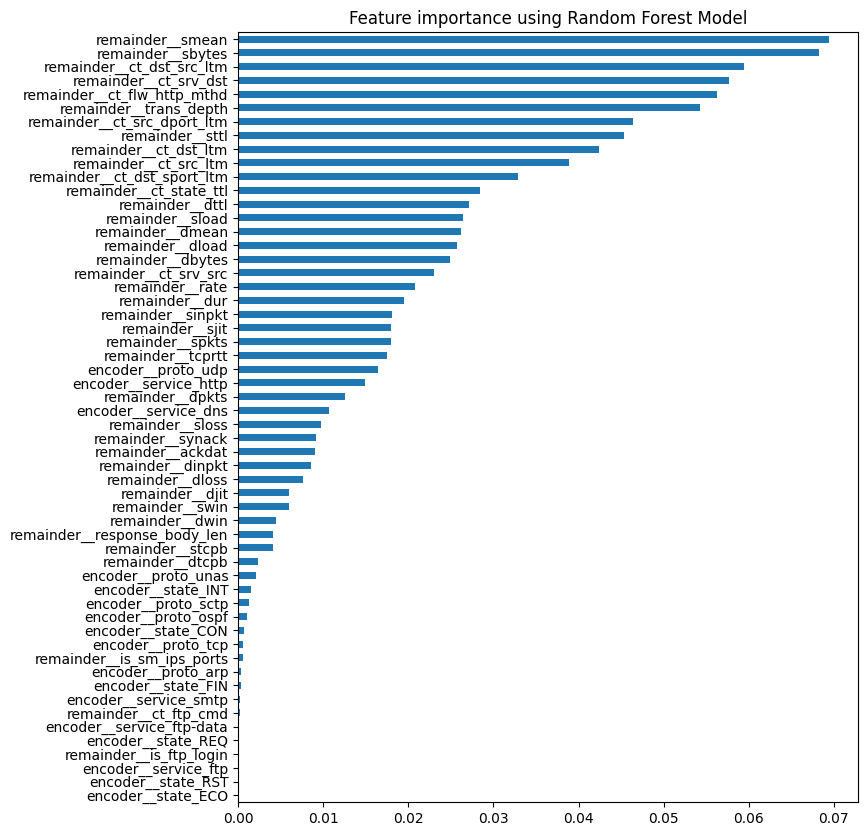

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=15)
numeric_cols = train_data_X.select_dtypes(include = "number")
rf_classifier.fit(numeric_cols, train_data_y.values.ravel())

feature_importances = pd.Series(rf_classifier.feature_importances_, index=numeric_cols.columns)

def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

plot_importance(feature_importances, 'Random Forest')

In [7]:
feature_importances

encoder__proto_arp              0.000311
encoder__proto_ospf             0.001044
encoder__proto_sctp             0.001308
encoder__proto_tcp              0.000619
encoder__proto_udp              0.016380
encoder__proto_unas             0.002054
encoder__service_dns            0.010718
encoder__service_ftp            0.000065
encoder__service_ftp-data       0.000163
encoder__service_http           0.014931
encoder__service_smtp           0.000242
encoder__state_CON              0.000703
encoder__state_ECO              0.000002
encoder__state_FIN              0.000307
encoder__state_INT              0.001511
encoder__state_REQ              0.000159
encoder__state_RST              0.000004
remainder__dur                  0.019442
remainder__spkts                0.017945
remainder__dpkts                0.012584
remainder__sbytes               0.068248
remainder__dbytes               0.024869
remainder__rate                 0.020755
remainder__sttl                 0.045384
remainder__dttl 

In [8]:
top_40_features = [
    "sttl",
    "PC1",
    "dttl",
    "ct_dst_src_ltm",
    "ct_dst_ltm",
    "ct_dst_sport_ltm",
    "ct_state_ttl",
    "ct_src_dport_ltm",
    "ct_src_ltm",
    "ct_srv_dst",
    "ct_srv_src",
    "ackdat",
    "tcprtt",
    "sbytes",
    "smean",
    "dload",
    "rate",
    "dmean",
    "dur",
    "PC3",
    "PC10",
    "dbytes",
    "synack",
    "PC2",
    "ct_flw_http_mthd",
    "trans_depth",
    "PC4",
    "sload",
    "PC5",
    "sinpkt",
    "PC8",
    "spkts",
    "dpkts",
    "PC9",
    "sloss",
    "sjit",
    "PC7",
    "dloss",
    "dwin",
    "swin"
]

In [9]:
from sklearn.feature_selection import f_classif #computes ANOVA 
from sklearn.feature_selection import SelectKBest  #Orders f statistics and selects the Kbest ones

def anova_test():

    
    X_vars = train_data_X[train_data_X.select_dtypes(include='number').columns]
    
    y_var = train_data_y
    
    anova = SelectKBest(f_classif, k=40) #we choose to keep the 10 best ones, try different numbers
    
    
    X_anova = anova.fit_transform(X_vars, y_var)
    
    anova_results = pd.DataFrame({'Feature': X_vars.columns, 
                                  'F-value': anova.scores_,
                                  'p-value': anova.pvalues_})
    
    anova_results.sort_values(by='F-value', ascending=False, inplace=True)

    
    selected_features = pd.Series(anova.get_support(), index = X_vars.columns)
    features_to_use = [feature for feature, keep in selected_features.items() if keep]

    features_to_use_str = '", "'.join(features_to_use)
    
    return selected_features, anova_results, features_to_use_str

In [10]:
anova_test()

C:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(encoder__proto_arp              False
 encoder__proto_ospf             False
 encoder__proto_sctp             False
 encoder__proto_tcp               True
 encoder__proto_udp               True
 encoder__proto_unas             False
 encoder__service_dns             True
 encoder__service_ftp            False
 encoder__service_ftp-data       False
 encoder__service_http            True
 encoder__service_smtp           False
 encoder__state_CON              False
 encoder__state_ECO              False
 encoder__state_FIN               True
 encoder__state_INT               True
 encoder__state_REQ              False
 encoder__state_RST              False
 remainder__dur                   True
 remainder__spkts                 True
 remainder__dpkts                 True
 remainder__sbytes                True
 remainder__dbytes                True
 remainder__rate                  True
 remainder__sttl                  True
 remainder__dttl                  True
 remainder__sload        

In [11]:
features = ["encoder__proto_tcp", "encoder__proto_udp", "encoder__service_dns", "encoder__service_http", "encoder__state_FIN", "encoder__state_INT", "remainder__dur", "remainder__spkts", "remainder__dpkts", "remainder__sbytes", "remainder__dbytes", "remainder__rate", "remainder__sttl", "remainder__dttl", "remainder__sload", "remainder__dload", "remainder__sloss", "remainder__dloss", "remainder__dinpkt", "remainder__sjit", "remainder__djit", "remainder__swin", "remainder__stcpb", "remainder__dtcpb", "remainder__dwin", "remainder__tcprtt", "remainder__synack", "remainder__ackdat", "remainder__smean", "remainder__dmean", "remainder__trans_depth", "remainder__ct_srv_src", "remainder__ct_state_ttl", "remainder__ct_dst_ltm", "remainder__ct_src_dport_ltm", "remainder__ct_dst_sport_ltm", "remainder__ct_dst_src_ltm", "remainder__ct_flw_http_mthd", "remainder__ct_src_ltm", "remainder__ct_srv_dst"]

# Modelling

## Modelling EfficentKan

In [12]:
#train_X_tensor = torch.tensor(train_data_X[features].values, dtype=torch.float32).squeeze()
#test_X_tensor = torch.tensor(test_data_X[features].values, dtype=torch.float32).squeeze() #changed to have all features

train_X_tensor = torch.tensor(train_data_X[features].values, dtype=torch.float32).squeeze()
test_X_tensor = torch.tensor(test_data_X[features].values, dtype=torch.float32).squeeze()

train_Y_tensor = torch.tensor(train_data_y.values, dtype=torch.long).squeeze()
test_Y_tensor = torch.tensor(test_labels_encoded.values, dtype=torch.long).squeeze()
#a dictionary with the 4 datasets

In [13]:
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [14]:

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Modelling with efficient Kan

In [16]:
from efficient_kan import KAN

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define model
model = KAN([40, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.CrossEntropyLoss()

In [18]:
model.grid_size, model.spline_order

(5, 3)

In [19]:
from sklearn.model_selection import KFold

In [20]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch 500: 2.261
Loss after mini-batch 1000: 1.916
Loss after mini-batch 1500: 1.567
Loss after mini-batch 2000: 1.296
Loss after mini-batch 2500: 1.141
Loss after mini-batch 3000: 1.033
Loss after mini-batch 3500: 0.942
Loss after mini-batch 4000: 0.872
Loss after mini-batch 4500: 0.800
Loss after mini-batch 5000: 0.782
Loss after mini-batch 5500: 0.728
Loss after mini-batch 6000: 0.703
Loss after mini-batch 6500: 0.680
Loss after mini-batch 7000: 0.648
Loss after mini-batch 7500: 0.655
Loss after mini-batch 8000: 0.628
Loss after mini-batch 8500: 0.610
Loss after mini-batch 9000: 0.593
Loss after mini-batch 9500: 0.576
Loss after mini-batch 10000: 0.572
Loss after mini-batch 10500: 0.549
Loss after mini-batch 11000: 0.528
Loss after mini-batch 11500: 0.494
Loss after mini-batch 12000: 0.505
Loss after mini-batch 12500: 0.477
Loss after mini-batch 13000: 0.468
Loss after mini-batc

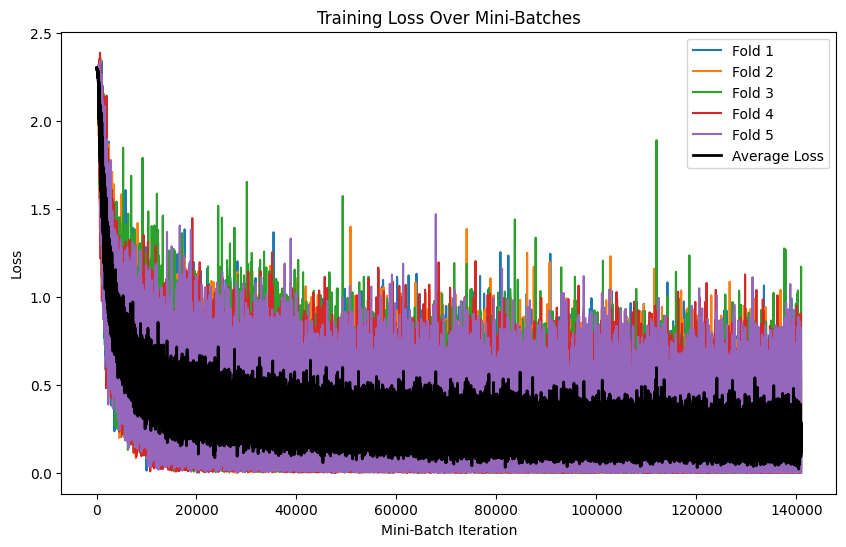

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Set fixed random seed
torch.manual_seed(42)

# Configuration options
k_folds = 5
num_epochs = 5
batch_size = 16
loss_function = nn.CrossEntropyLoss()
results = {}

# Convert data to PyTorch tensors (assuming `train_X_tensor`, `test_X_tensor`, `train_Y_tensor`, `test_Y_tensor` exist)
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)

# Concatenate train and test dataset for cross-validation
dataset = ConcatDataset([train_dataset, test_dataset])

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# Initialize a list to store loss values across folds
all_losses = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    testloader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    # Init the neural network
    model = KAN([40, 64,32, 16,10])
    model.grid_size

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Initialize a list to store loss values for this fold
    fold_losses = []

    # Run the training loop for defined number of epochs
    model.train()
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch + 1}')
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, (inputs, targets) in enumerate(trainloader, 0):

            inputs, targets = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")), targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, targets)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Store the loss value
            fold_losses.append(loss.item())

            # Print statistics
            current_loss += loss.item()
            if i % 500 == 499:
                print(f'Loss after mini-batch {i + 1}: {current_loss / 500:.3f}')
                current_loss = 0.0

    # Store the loss values for this fold
    all_losses.append(fold_losses)

    print('Training process has finished. Starting testing...')

    # Evaluation for this fold
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")), targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            # Generate outputs
            outputs = model(inputs)

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store predictions and labels for precision, recall, F1
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # Compute metrics
    accuracy = 100.0 * correct / total
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f'Fold {fold} Results:')
    print(f'Accuracy: {accuracy:.2f} %')
    print(f'Precision: {precision:.2f} %')
    print(f'Recall: {recall:.2f} %')
    print(f'F1 Score: {f1:.2f} %')
    print('--------------------------------')

    results[fold] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}

# Print final K-Fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')

# Compute and print average scores
avg_accuracy = np.mean([results[fold]["accuracy"] for fold in results])
avg_precision = np.mean([results[fold]["precision"] for fold in results])
avg_recall = np.mean([results[fold]["recall"] for fold in results])
avg_f1 = np.mean([results[fold]["f1_score"] for fold in results])

for fold, metrics in results.items():
    print(f'Fold {fold}: Accuracy: {metrics["accuracy"]:.2f}%, Precision: {metrics["precision"]:.2f}%, Recall: {metrics["recall"]:.2f}%, F1 Score: {metrics["f1_score"]:.2f}%')

print('--------------------------------')
print(f'Average Accuracy: {avg_accuracy:.2f} %')
print(f'Average Precision: {avg_precision:.2f} %')
print(f'Average Recall: {avg_recall:.2f} %')
print(f'Average F1 Score: {avg_f1:.2f} %')

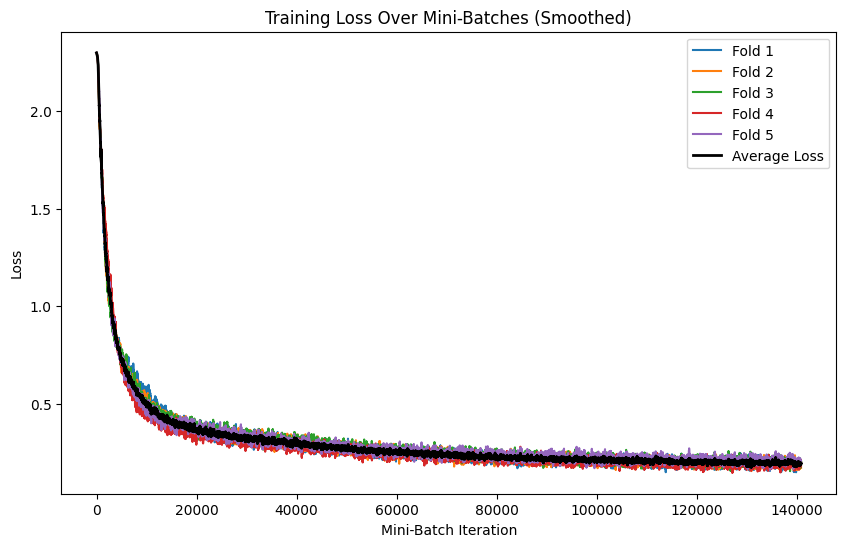

In [41]:
# Smoothing function using a moving average
def smooth_loss(losses, window_size=100):
    """
    Smooth the loss values using a moving average.
    :param losses: List of loss values.
    :param window_size: Size of the moving window.
    :return: Smoothed loss values.
    """
    smoothed_losses = np.convolve(losses, np.ones(window_size) / window_size, mode='valid')
    return smoothed_losses

# Plot the training loss over time
plt.figure(figsize=(10, 6))

# Smooth and plot training loss for each fold
for fold, losses in enumerate(all_losses):
    smoothed_loss = smooth_loss(losses, window_size=100)  # Adjust window_size as needed
    plt.plot(smoothed_loss, label=f'Fold {fold + 1}')

# Calculate and plot the average smoothed loss across folds
avg_loss = np.mean(all_losses, axis=0)
smoothed_avg_loss = smooth_loss(avg_loss, window_size=100)
plt.plot(smoothed_avg_loss, label='Average Loss', linewidth=2, color='black')

plt.xlabel('Mini-Batch Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Mini-Batches (Smoothed)')
plt.legend()
plt.show()

In [23]:
print(f"Total Mini-Batches per Epoch: {len(trainloader)}")

Total Mini-Batches per Epoch: 28190


# Confusion Matrix

In [26]:
import pickle
import pandas as pd

# Load the LabelEncoder object from the file
with open(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


# Now you can use the label_encoder object in the second notebook
original_class_labels = label_encoder.classes_

In [27]:
original_labels_test = label_encoder.inverse_transform(test_labels_encoded.values.flatten())

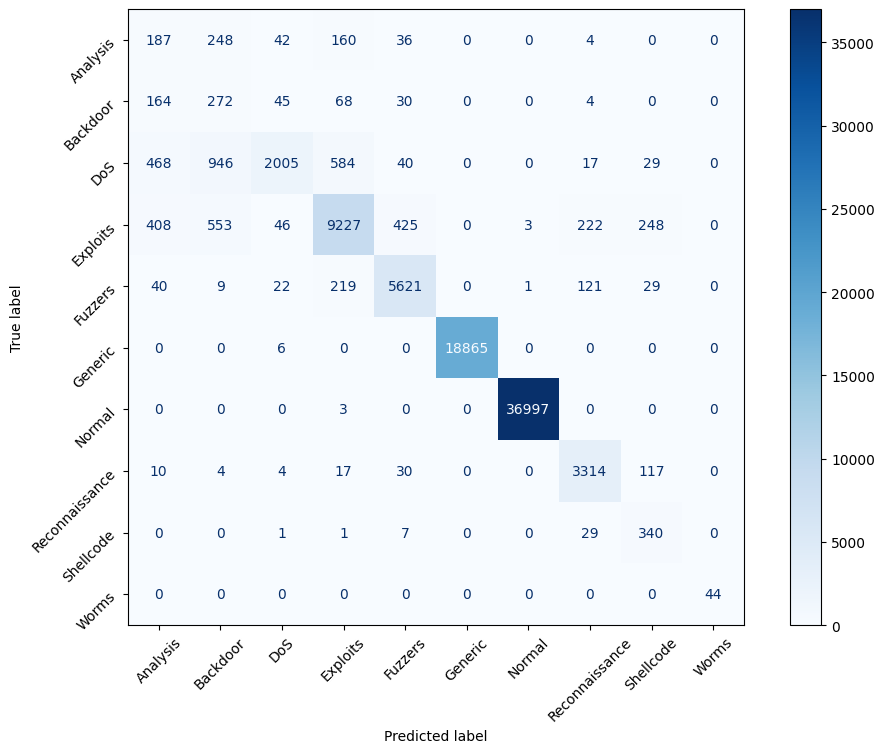

In [28]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the model is in evaluation mode
model.eval()

with torch.no_grad():
    y_pred = model(test_X_tensor)  # Forward pass
    y_pred = torch.argmax(y_pred, dim=1)  # Get class predictions

# Convert tensors to NumPy arrays for sklearn
y_pred = y_pred.cpu().numpy()
y_true = test_Y_tensor.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

fig, ax = plt.subplots(figsize=(12, 8))  #Creates both a figure and an ax

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Rotate axis labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [29]:
import torch.nn.functional as F

with torch.no_grad():
    y_score = F.softmax(model(test_X_tensor), dim=1)

In [30]:
np.average(y_score.numpy())

np.float32(0.1)

In [31]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(train_data_y)
y_onehot_test = label_binarizer.transform(test_labels_encoded)
y_onehot_test.shape  # (n_samples, n_classes)

(82332, 10)

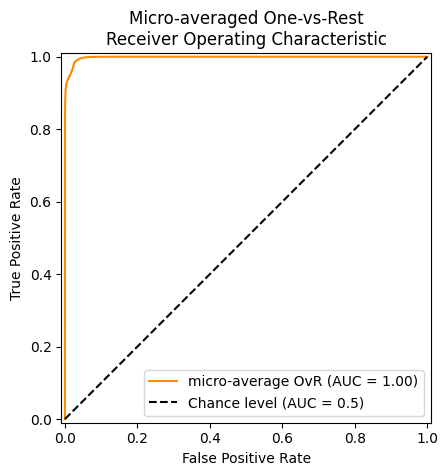

In [32]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)